In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from app.service.preparation.preparation import get_stocks_as_dataframe

Matplotlib is building the font cache; this may take a moment.


ModuleNotFoundError: No module named 'keras'

In [79]:
data = get_stocks_as_dataframe("ALK")

In [81]:
data.head(10)

,Unnamed: 0,max_price,company,closing_price,avg_price,volume,date,min_price,percentage_change,total_turnover
0,242,5000.0,ALK,5000.0,5000.00,103,2014-12-15,5000.0,"-0,96",515000.0
1,241,5002.0,ALK,5002.0,5001.74,38,2014-12-16,5001.0,"0,03",190066.0
2,240,5030.0,ALK,5005.0,5017.70,200,2014-12-17,5002.0,"0,32",1003540.0
3,239,5030.0,ALK,5005.0,5026.74,230,2014-12-18,5005.0,"0,18",1156150.0
4,238,5005.0,ALK,5005.0,5005.00,314,2014-12-19,5005.0,"-0,43",1571570.0
5,237,5030.0,ALK,5000.0,5022.78,45,2014-12-22,5000.0,"0,36",226025.0
6,236,5030.0,ALK,5001.0,5024.83,544,2014-12-23,5000.0,"0,04",2733505.0
7,235,5000.0,ALK,5000.0,5000.00,514,2014-12-24,5000.0,"-0,49",2570000.0
8,234,5030.0,ALK,5030.0,5029.05,644,2014-12-25,5020.0,"0,58",3238705.0
9,233,5050.0,ALK,5050.0,5050.00,6,2014-12-26,5050.0,"0,42",30300.0


In [83]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2450 entries, 0 to 2449
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         2450 non-null   int64  
 1   max_price          2450 non-null   float64
 2   company            2450 non-null   object 
 3   closing_price      2450 non-null   float64
 4   avg_price          2450 non-null   float64
 5   volume             2450 non-null   object 
 6   date               2450 non-null   object 
 7   min_price          2450 non-null   float64
 8   percentage_change  2450 non-null   object 
 9   total_turnover     2450 non-null   float64
dtypes: float64(5), int64(1), object(4)
memory usage: 191.5+ KB


In [85]:
data.drop('Unnamed: 0', axis=1, inplace=True)

In [87]:
data = data.set_index('date')
data = data.sort_index()

In [89]:
data

,max_price,company,closing_price,avg_price,volume,min_price,percentage_change,total_turnover
date,,,,,,,,
2014-12-15,5000.0,ALK,5000.0,5000.00,103,5000.0,"-0,96",515000.0
2014-12-16,5002.0,ALK,5002.0,5001.74,38,5001.0,"0,03",190066.0
2014-12-17,5030.0,ALK,5005.0,5017.70,200,5002.0,"0,32",1003540.0
2014-12-18,5030.0,ALK,5005.0,5026.74,230,5005.0,"0,18",1156150.0
2014-12-19,5005.0,ALK,5005.0,5005.00,314,5005.0,"-0,43",1571570.0
...,...,...,...,...,...,...,...,...
2024-12-03,25550.0,ALK,25550.0,25415.78,258,25379.0,"0,14",6557272.0
2024-12-04,25900.0,ALK,25900.0,25529.34,242,25402.0,"0,45",6178100.0
2024-12-05,27499.0,ALK,27499.0,26704.83,358,26200.0,"4,60",9560330.0


## **Univariate forecasting**

In [92]:
df1 = data.copy()

In [94]:
lag = 7

In [96]:
for i in range(1, lag + 1):
  df1[f'closing_price_prev_{i}'] = df1['closing_price'].shift(i)

In [98]:
df1 = df1.dropna(axis=0)

In [100]:
df1.head(10)

,max_price,company,closing_price,avg_price,volume,min_price,percentage_change,total_turnover,closing_price_prev_1,closing_price_prev_2,closing_price_prev_3,closing_price_prev_4,closing_price_prev_5,closing_price_prev_6,closing_price_prev_7
date,,,,,,,,,,,,,,,
2014-12-24,5000.0,ALK,5000.0,5000.00,514,5000.0,"-0,49",2570000.0,5001.0,5000.0,5005.0,5005.0,5005.0,5002.0,5000.0
2014-12-25,5030.0,ALK,5030.0,5029.05,644,5020.0,"0,58",3238705.0,5000.0,5001.0,5000.0,5005.0,5005.0,5005.0,5002.0
2014-12-26,5050.0,ALK,5050.0,5050.00,6,5050.0,"0,42",30300.0,5030.0,5000.0,5001.0,5000.0,5005.0,5005.0,5005.0
2014-12-29,5050.0,ALK,5050.0,5049.86,820,5049.0,"0,00",4140886.0,5050.0,5030.0,5000.0,5001.0,5000.0,5005.0,5005.0
2014-12-30,5100.0,ALK,5100.0,5087.79,68,5070.0,"0,75",345970.0,5050.0,5050.0,5030.0,5000.0,5001.0,5000.0,5005.0
2015-01-02,5100.0,ALK,5100.0,5100.00,40,5100.0,"0,24",204000.0,5100.0,5050.0,5050.0,5030.0,5000.0,5001.0,5000.0
2015-01-05,5050.0,ALK,5050.0,5050.00,14,5050.0,"-0,98",70700.0,5100.0,5100.0,5050.0,5050.0,5030.0,5000.0,5001.0
2015-01-08,5100.0,ALK,5050.0,5084.93,229,5050.0,"0,69",1164450.0,5050.0,5100.0,5100.0,5050.0,5050.0,5030.0,5000.0
2015-01-09,5050.0,ALK,5040.0,5033.55,307,5005.0,"-1,01",1545300.0,5050.0,5050.0,5100.0,5100.0,5050.0,5050.0,5030.0


In [102]:
features = [f'closing_price_prev_{i}' for i in range(1, lag + 1)]

In [104]:
X, Y = df1[features], df1['closing_price']

In [106]:
X

,closing_price_prev_1,closing_price_prev_2,closing_price_prev_3,closing_price_prev_4,closing_price_prev_5,closing_price_prev_6,closing_price_prev_7
date,,,,,,,
2014-12-24,5001.0,5000.0,5005.0,5005.0,5005.0,5002.0,5000.0
2014-12-25,5000.0,5001.0,5000.0,5005.0,5005.0,5005.0,5002.0
2014-12-26,5030.0,5000.0,5001.0,5000.0,5005.0,5005.0,5005.0
2014-12-29,5050.0,5030.0,5000.0,5001.0,5000.0,5005.0,5005.0
2014-12-30,5050.0,5050.0,5030.0,5000.0,5001.0,5000.0,5005.0
...,...,...,...,...,...,...,...
2024-12-03,25400.0,25300.0,25290.0,25244.0,25205.0,25200.0,25100.0
2024-12-04,25550.0,25400.0,25300.0,25290.0,25244.0,25205.0,25200.0
2024-12-05,25900.0,25550.0,25400.0,25300.0,25290.0,25244.0,25205.0


In [108]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, shuffle=False)

In [110]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
Y_train = scaler.fit_transform(Y_train.values.reshape(-1, 1))

In [112]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

In [114]:
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [116]:
model = Sequential()
model.add(LSTM(100,  activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(50,  activation='relu'))
model.add(Dense(1, activation='linear'))

C:\Users\ivasp\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [118]:
model.compile(loss=keras.losses.MeanSquaredError() , optimizer=keras.optimizers.Adam(), metrics=[keras.metrics.MeanSquaredError(), keras.metrics.MeanAbsoluteError() ])

In [120]:
history = model.fit(X_train, Y_train, batch_size=16, validation_split=0.2, epochs=20, shuffle=False)

Epoch 1/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - loss: 5.3653e-04 - mean_absolute_error: 0.0187 - mean_squared_error: 5.3653e-04 - val_loss: 0.0161 - val_mean_absolute_error: 0.1114 - val_mean_squared_error: 0.0161
Epoch 2/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0111 - mean_absolute_error: 0.0758 - mean_squared_error: 0.0111 - val_loss: 0.0136 - val_mean_absolute_error: 0.1018 - val_mean_squared_error: 0.0136
Epoch 3/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0123 - mean_absolute_error: 0.0867 - mean_squared_error: 0.0123 - val_loss: 0.0029 - val_mean_absolute_error: 0.0439 - val_mean_squared_error: 0.0029
Epoch 4/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0166 - mean_absolute_error: 0.1007 - mean_squared_error: 0.0166 - val_loss: 0.0095 - val_mean_absolute_error: 0.0917 - val_mean_squared_error: 0.0095
Epoch 5/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0106 - mean_absolute_error: 0.0867 - mean_squared_error: 0.0106 - val_loss: 0.0036 - v

In [122]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 7, 100)              │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 213,155 (832.64 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 142,104 (555.10 KB)

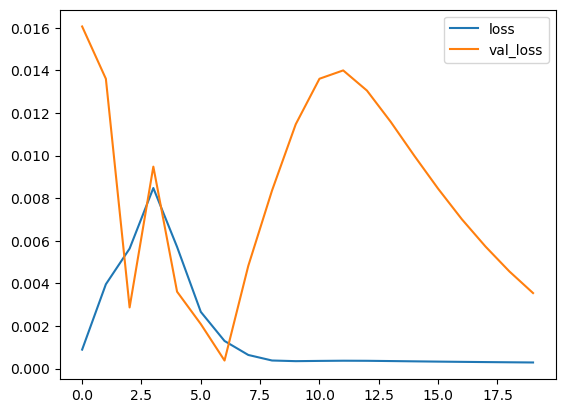

In [124]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

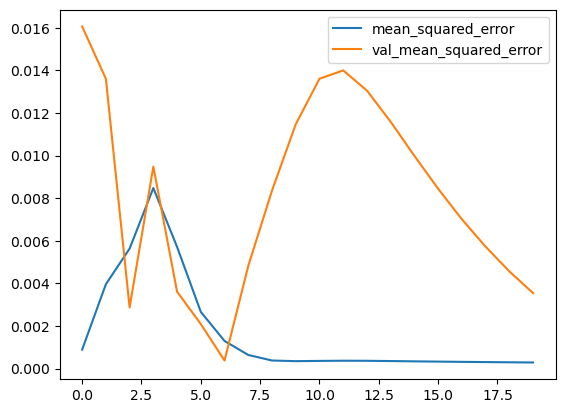

In [126]:
plt.plot(history.history['mean_squared_error'], label='mean_squared_error')
plt.plot(history.history['val_mean_squared_error'], label='val_mean_squared_error')
plt.legend()
plt.show()

In [140]:
preds = model.predict(X_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [142]:
preds = scaler.inverse_transform(preds)

In [144]:
mean_squared_error(preds, Y_test), mean_absolute_error(preds, Y_test), r2_score(preds, Y_test)

(2606452.1661014897, 1536.0138264196794, 0.5814173791021138)

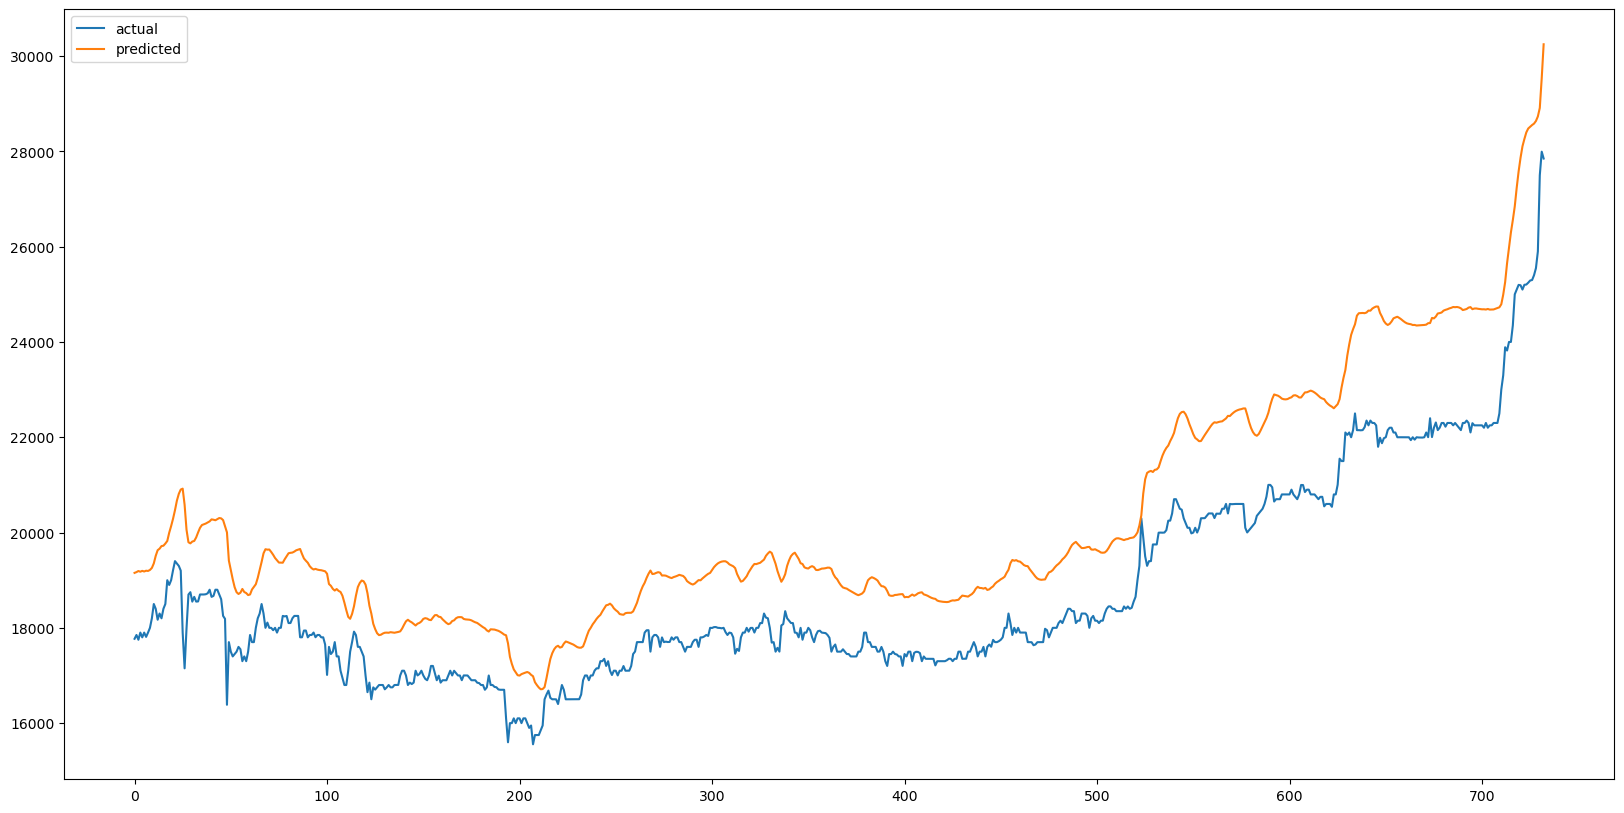

In [146]:
plt.figure(figsize=(20, 10))
plt.plot(Y_test.values, label='actual')
plt.plot(preds, label='predicted')
plt.legend()
plt.show()

## **Multivariate Prediction**

In [343]:
df2 = data.copy()

In [345]:
df2['percentage_change'] = df2['percentage_change'].str.replace(',', '.').astype(float)

In [347]:
df2['volume'] = df2['volume'].str.replace(',','').astype(float)

In [349]:
columns = df2.columns.drop(['company','percentage_change','avg_price','total_turnover','volume'])

In [351]:
lag=7

In [353]:
for i in range(1, lag+1):
  for col in columns:
    df2[f'{col}_prev_{i}'] = df2[col].shift(i)

In [355]:
df2 = df2.dropna(axis=0)

In [357]:
features = df2.columns.drop(['max_price', 'company', 'closing_price', 'avg_price', 'volume', 'min_price', 'percentage_change', 'total_turnover'])

In [359]:
features

Index(['max_price_prev_1', 'closing_price_prev_1', 'min_price_prev_1',
       'max_price_prev_2', 'closing_price_prev_2', 'min_price_prev_2',
       'max_price_prev_3', 'closing_price_prev_3', 'min_price_prev_3',
       'max_price_prev_4', 'closing_price_prev_4', 'min_price_prev_4',
       'max_price_prev_5', 'closing_price_prev_5', 'min_price_prev_5',
       'max_price_prev_6', 'closing_price_prev_6', 'min_price_prev_6',
       'max_price_prev_7', 'closing_price_prev_7', 'min_price_prev_7'],
      dtype='object')

In [361]:
X, Y = df2[features], df2['closing_price']

In [363]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, shuffle=False)

In [365]:
X_train

,max_price_prev_1,closing_price_prev_1,min_price_prev_1,max_price_prev_2,closing_price_prev_2,min_price_prev_2,max_price_prev_3,closing_price_prev_3,min_price_prev_3,max_price_prev_4,...,min_price_prev_4,max_price_prev_5,closing_price_prev_5,min_price_prev_5,max_price_prev_6,closing_price_prev_6,min_price_prev_6,max_price_prev_7,closing_price_prev_7,min_price_prev_7
date,,,,,,,,,,,,,,,,,,,,,
2014-12-24,5030.0,5001.0,5000.0,5030.0,5000.0,5000.0,5005.0,5005.0,5005.0,5030.0,...,5005.0,5030.0,5005.0,5002.0,5002.0,5002.0,5001.0,5000.0,5000.0,5000.0
2014-12-25,5000.0,5000.0,5000.0,5030.0,5001.0,5000.0,5030.0,5000.0,5000.0,5005.0,...,5005.0,5030.0,5005.0,5005.0,5030.0,5005.0,5002.0,5002.0,5002.0,5001.0
2014-12-26,5030.0,5030.0,5020.0,5000.0,5000.0,5000.0,5030.0,5001.0,5000.0,5030.0,...,5000.0,5005.0,5005.0,5005.0,5030.0,5005.0,5005.0,5030.0,5005.0,5002.0
2014-12-29,5050.0,5050.0,5050.0,5030.0,5030.0,5020.0,5000.0,5000.0,5000.0,5030.0,...,5000.0,5030.0,5000.0,5000.0,5005.0,5005.0,5005.0,5030.0,5005.0,5005.0
2014-12-30,5050.0,5050.0,5049.0,5050.0,5050.0,5050.0,5030.0,5030.0,5020.0,5000.0,...,5000.0,5030.0,5001.0,5000.0,5030.0,5000.0,5000.0,5005.0,5005.0,5005.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-06,17600.0,17600.0,17500.0,17600.0,17500.0,17450.0,17600.0,17600.0,17400.0,17499.0,...,17300.0,17499.0,17499.0,17311.0,17512.0,17499.0,17498.0,17650.0,17599.0,17590.0
2021-12-07,17700.0,17680.0,17650.0,17600.0,17600.0,17500.0,17600.0,17500.0,17450.0,17600.0,...,17400.0,17499.0,17450.0,17300.0,17499.0,17499.0,17311.0,17512.0,17499.0,17498.0
2021-12-09,17799.0,17790.0,17789.0,17700.0,17680.0,17650.0,17600.0,17600.0,17500.0,17600.0,...,17450.0,17600.0,17600.0,17400.0,17499.0,17450.0,17300.0,17499.0,17499.0,17311.0


In [367]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
Y_train = scaler.fit_transform(Y_train.values.reshape(-1, 1))

In [369]:
X_train = X_train.reshape(X_train.shape[0], lag, X_train.shape[1] // lag)
X_test = X_test.reshape(X_test.shape[0], lag, X_test.shape[1] // lag)

In [371]:
model = Sequential()
model.add(LSTM(100,  activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(50,  activation='relu'))
model.add(Dense(1, activation='linear'))

C:\Users\ivasp\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [373]:
# model = Sequential()
# model.add(LSTM(128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
# model.add(Dropout(0.2)) 
# model.add(LSTM(64, activation='relu', return_sequences=False))
# model.add(Dropout(0.2))
# model.add(Dense(32, activation='relu'))  
# model.add(Dense(1, activation='linear'))
# model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae'])

In [375]:
model.compile(loss=keras.losses.MeanSquaredError() , optimizer=keras.optimizers.Adam(), metrics=[keras.metrics.MeanSquaredError(), keras.metrics.MeanAbsoluteError() ])

In [389]:
history = model.fit(X_train, Y_train, validation_split=0.2, batch_size=64, epochs=100,  shuffle=False)

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 3.8865e-04 - mean_absolute_error: 0.0169 - mean_squared_error: 3.8865e-04 - val_loss: 0.0051 - val_mean_absolute_error: 0.0589 - val_mean_squared_error: 0.0051
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 1.5537e-04 - mean_absolute_error: 0.0087 - mean_squared_error: 1.5537e-04 - val_loss: 0.0018 - val_mean_absolute_error: 0.0344 - val_mean_squared_error: 0.0018
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 7.0871e-04 - mean_absolute_error: 0.0229 - mean_squared_error: 7.0871e-04 - val_loss: 0.0016 - val_mean_absolute_error: 0.0310 - val_mean_squared_error: 0.0016
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0020 - mean_absolute_error: 0.0414 - mean_squared_error: 0.0020 - val_loss: 0.0106 - val_mean_absolute_error: 0.0943 - val_mean_squared_error: 0.0106
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 8.1911e-04 - mean_absolute_error: 0.0230 - mean_squared_error: 8.191

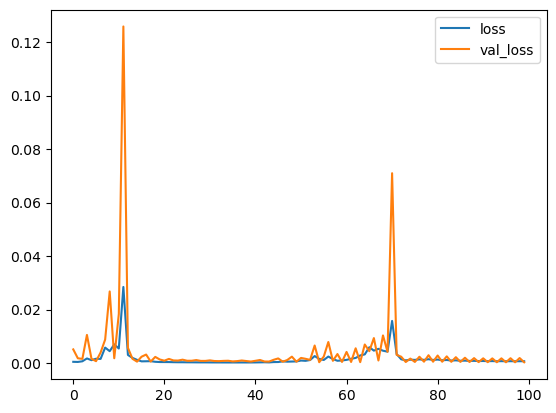

In [391]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

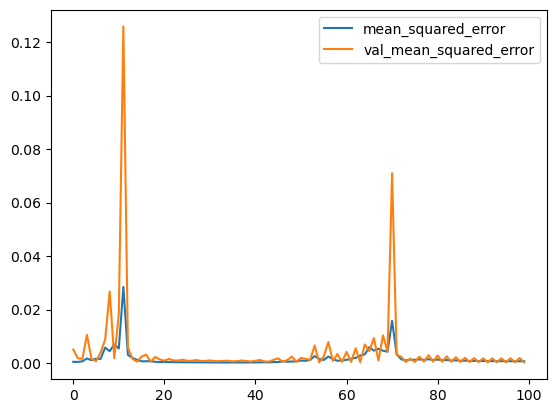

In [393]:
plt.plot(history.history['mean_squared_error'], label='mean_squared_error')
plt.plot(history.history['val_mean_squared_error'], label='val_mean_squared_error')
plt.legend()
plt.show()

In [395]:
preds2 = model.predict(X_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [397]:
preds2 = scaler.inverse_transform(preds2)

In [399]:
mean_squared_error(preds2, Y_test), mean_absolute_error(preds2, Y_test), r2_score(preds2, Y_test)

(83316.09396805314, 183.33289057170873, 0.980450280768094)

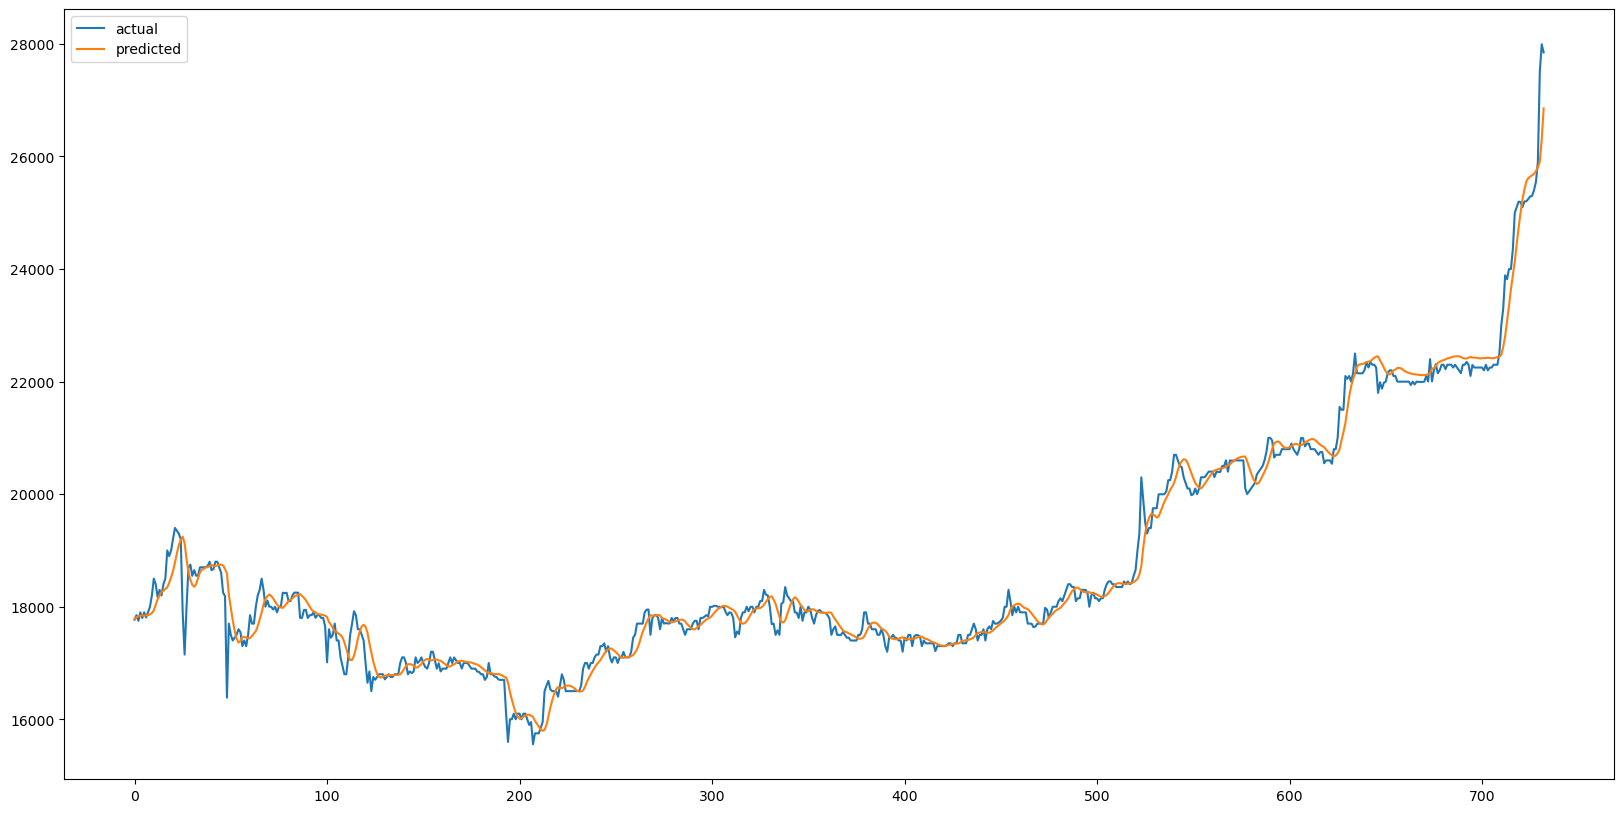

In [401]:
plt.figure(figsize=(20, 10))
plt.plot(Y_test.values, label='actual')
plt.plot(preds2, label='predicted')
plt.legend()
plt.show()